In [189]:
import pg8000
import datetime
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
conn = pg8000.connect(database= 'training', port = 5432, host = 'training.c1erymiua9dx.us-east-1.rds.amazonaws.com', user = 'dot_student', password = 'qgis')

In [56]:
conn.rollback()

In [36]:
cursor = conn.cursor()

What does this data look like?

In [39]:
cursor.execute("""SELECT * 
    FROM dot_311 
    LIMIT 1""")
cursor.fetchone()

[2,
 Decimal('32570549'),
 'DOT',
 'Department of Transportation',
 'Traffic Signal Condition',
 'Controller',
 None,
 Decimal('10301'),
 None,
 None,
 None,
 None,
 'VICTORY BOULEVARD',
 'LITTLE CLOVE ROAD',
 'INTERSECTION',
 'STATEN ISLAND',
 None,
 'N/A',
 'Closed',
 None,
 None,
 '02/01/2016 01:15:00 AM',
 '01 STATEN ISLAND',
 'STATEN ISLAND',
 Decimal('952773'),
 Decimal('162922'),
 'Unspecified',
 'STATEN ISLAND',
 'Unspecified',
 'Unspecified',
 'Unspecified',
 'Unspecified',
 'Unspecified',
 'Unspecified',
 'Unspecified',
 'Unspecified',
 'Unspecified',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 Decimal('40.613803753157917'),
 Decimal('-74.113373738864198'),
 '(40.61380375315792, -74.1133737388642)',
 '0101000020E61000006829ED83418752C0D7FC121F914E4440',
 datetime.datetime(2016, 2, 1, 0, 12),
 datetime.datetime(2016, 2, 1, 1, 15)]

What are the column names?

In [46]:
cursor.execute("""SELECT column_name FROM information_schema.columns WHERE table_name='dot_311'""")
cursor.fetchall()

(['gid'],
 ['unique_key'],
 ['agency'],
 ['agency nam'],
 ['complaint'],
 ['descriptor'],
 ['location t'],
 ['incident z'],
 ['incident a'],
 ['street nam'],
 ['cross stre'],
 ['cross st_1'],
 ['intersecti'],
 ['intersec_1'],
 ['address ty'],
 ['city'],
 ['landmark'],
 ['facility t'],
 ['status'],
 ['due date'],
 ['resolution'],
 ['resoluti_1'],
 ['community'],
 ['borough'],
 ['x coordina'],
 ['y coordina'],
 ['park facil'],
 ['park borou'],
 ['school nam'],
 ['school num'],
 ['school reg'],
 ['school cod'],
 ['school pho'],
 ['school add'],
 ['school cit'],
 ['school sta'],
 ['school zip'],
 ['school not'],
 ['school or'],
 ['vehicle ty'],
 ['taxi compa'],
 ['taxi pick'],
 ['bridge hig'],
 ['bridge h_1'],
 ['road ramp'],
 ['bridge h_2'],
 ['garage lot'],
 ['ferry dire'],
 ['ferry term'],
 ['latitude'],
 ['longitude'],
 ['location'],
 ['geom'],
 ['created_date'],
 ['closed_date'])

What does a created and closed date look like?

In [53]:
cursor.execute("""SELECT created_date, closed_date 
    FROM dot_311 
    LIMIT 1""")
cursor.fetchone()

([datetime.datetime(2016, 2, 1, 0, 12), datetime.datetime(2016, 2, 1, 1, 15)],)

Okay, let's just save the created and closed dates.

In [57]:
cursor.execute("""SELECT created_date, closed_date 
    FROM dot_311""")
results = cursor.fetchall()

Exploring how to convert them into the length of time the complaints are open.

In [62]:
results[0][0]

datetime.datetime(2016, 2, 1, 0, 12)

In [63]:
results[0][1]

datetime.datetime(2016, 2, 1, 1, 15)

In [64]:
results[0][1] - results[0][0]

datetime.timedelta(0, 3780)

In [71]:
dif = results[0][1] - results[0][0]
divmod(dif.days * 86400 + dif.seconds, 60)
# datetime.datetime.strftime(datetime.timedelta(0, 3780), "%H:%M")

(63, 0)

In [79]:
dif = results[0][1] - results[0][0]
divmod(dif.seconds, 60)

(63, 0)

In [117]:
dif = datetime.timedelta(2, 3780)

In [119]:
dif.days * 1440 + dif.seconds/60

2943.0

In [73]:
results[:3]

([datetime.datetime(2016, 2, 1, 0, 12), datetime.datetime(2016, 2, 1, 1, 15)],
 [datetime.datetime(2016, 2, 1, 0, 14), datetime.datetime(2016, 2, 1, 0, 54)],
 [datetime.datetime(2016, 2, 1, 0, 15), datetime.datetime(2016, 2, 1, 1, 30)])

In [83]:
timelen = []
for created, closed in results[:3]:
    print('created', created)
    print('closed', closed)
    print('')

created 2016-02-01 00:12:00
closed 2016-02-01 01:15:00

created 2016-02-01 00:14:00
closed 2016-02-01 00:54:00

created 2016-02-01 00:15:00
closed 2016-02-01 01:30:00



Okay, let's make a list of how many minutes each one of these is open!

In [120]:
timelen = []
for created, closed in results:
    if created and closed:
        dif = closed - created
        timelen.append(dif.days * 1440 + dif.seconds/60)

201 or 1.7% of the items didn't have both a closed and created time

In [121]:
len(results) - len(timelen)

201

In [122]:
201 / (len(results) + len(timelen))

0.01747674115294322

And at least 1103 of the results are probably not accurate.

In [123]:
num = 0
for time in timelen:
    if time <= 0:
        num += 1
print(num)

1103


In [124]:
sorted(timelen)[:20]

[-26791.0,
 -26747.0,
 -26693.0,
 -17280.0,
 -9736.0,
 -9241.0,
 -9240.0,
 -9240.0,
 -8940.0,
 -8940.0,
 -8880.0,
 -8671.0,
 -8641.0,
 -8641.0,
 -8641.0,
 -8641.0,
 -8641.0,
 -8640.0,
 -8640.0,
 -8640.0]

Let's turn this into a Pandas DataFrame.

In [125]:
df = pd.DataFrame({'timelen': timelen})

Okay, let's make a histogram showing how many incidents happen. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bdde240>]], dtype=object)

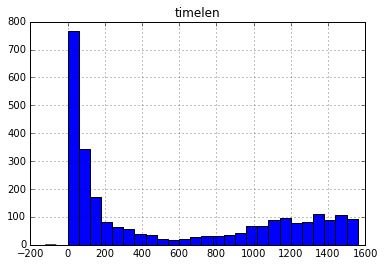

In [131]:
df.hist(bins = 28, range = (-120, 1560))

Looks like those 1103 0-minute cases are all outliers that are going to mess things up.

# Measures of Center

## Mean

In [132]:
df.mean()

timelen    9545.093156
dtype: float64

In [157]:
df[df['timelen'] >= 0].mean()

timelen    11210.542883
dtype: float64

## Median

The mean is a LOT higher than the median, which suggests the data is skewed.

In [133]:
df.median()

timelen    1308.25
dtype: float64

In [158]:
df[df['timelen'] >= 0].median()

timelen    1476.558333
dtype: float64

## Mode

In [134]:
df.mode()

,timelen
0,0.0


In [159]:
df[df['timelen'] >= 0].mode()

,timelen
0,0.0


# Measures of Spread

## Range

In [164]:
max(timelen) - min(timelen)

156085.0

In [161]:
df[df['timelen'] >= 0].max() - df[df['timelen'] >= 0].min()

timelen    129294.0
dtype: float64

## Standard Deviation

In [163]:
df.std()

timelen    20885.63768
dtype: float64

In [162]:
df[df['timelen'] >= 0].std()

timelen    21412.331573
dtype: float64

If you think outliers are numbers three standard deviations away from the mean, there are 68 outliers, but it doesn't catch all of the negative values.

In [137]:
df.mean() + df.std() * 3

timelen    72202.006197
dtype: float64

In [138]:
df.mean() - df.std() * 3

timelen   -53111.819884
dtype: float64

In [178]:
std_outliers = df[(df['timelen'] < -53111.819884) | (df['timelen'] > 72202.006197)]

In [179]:
len(std_outliers)

68

In [165]:
std_outliers.head()

,timelen
31,85300.0
37,90871.0
142,116740.0
361,81365.0
491,72671.0


In [172]:
df[df['timelen'] >= 0].mean() + df[df['timelen'] >= 0].std() * 3

timelen    75447.537602
dtype: float64

In [173]:
df[df['timelen'] >= 0].mean() - df[df['timelen'] >= 0].std() * 3

timelen   -53026.451835
dtype: float64

In [175]:
std_outliers = df[df['timelen'] > 75447.537602]

In [176]:
len(std_outliers)

62

In [177]:
std_outliers.head()

,timelen
31,85300.0
37,90871.0
142,116740.0
361,81365.0
493,100622.0


## Interquartile Range

In [145]:
IQR = df.quantile(q=0.75) - df.quantile(q=0.25)

In [146]:
IQR

timelen    5716.808333
dtype: float64

In [181]:
IQR2 = df[df['timelen'] >= 0].quantile(q=0.75) - df[df['timelen'] >= 0].quantile(q=0.25)

In [182]:
IQR2

timelen    7064.391667
dtype: float64

If you think outliers are 1.5 times the interquartile range above the 3rd quartile or below the 1st quartile, there are 1067 outliers, more than with the standard deviation outliers, but still not getting rid of the negative values.

In [152]:
df.quantile(q=0.25) - 1.5 * IQR

timelen   -8501.2125
dtype: float64

In [153]:
df.quantile(q=0.75) + 1.5 * IQR

timelen    14366.020833
dtype: float64

In [154]:
IQR_outliers = df[(df['timelen'] < -8501.2125) | (df['timelen'] > 14366.020833)]

In [155]:
len(IQR_outliers)

1067

In [183]:
IQR_outliers.head()

,timelen
31,85300.000000
33,33507.000000
37,90871.000000
137,63416.366667
142,116740.000000


In [184]:
df[df['timelen'] >= 0].quantile(q=0.25) - 1.5 * IQR2

timelen   -10423.5875
dtype: float64

In [185]:
df[df['timelen'] >= 0].quantile(q=0.75) + 1.5 * IQR2

timelen    17833.979167
dtype: float64

In [186]:
IQR_outliers2 = df[(df['timelen'] > 14366.020833)]

In [187]:
len(IQR_outliers2)

938

In [188]:
IQR_outliers2.head()

,timelen
31,85300.000000
33,33507.000000
37,90871.000000
137,63416.366667
142,116740.000000


## Box and Whiskers

{'boxes': [<matplotlib.lines.Line2D at 0x10c4481d0>],
 'caps': [<matplotlib.lines.Line2D at 0x10c44fbe0>,
 'fliers': [<matplotlib.lines.Line2D at 0x10c455d68>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10c455550>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10c448b70>,
  <matplotlib.lines.Line2D at 0x10c448c88>]}

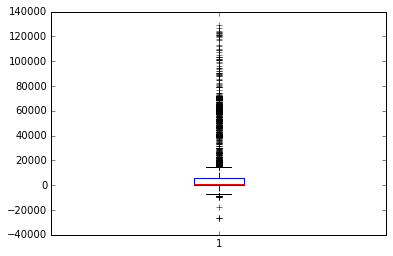

In [195]:
plt.boxplot(df['timelen'])

{'boxes': [<matplotlib.lines.Line2D at 0x10c73c0f0>],
 'caps': [<matplotlib.lines.Line2D at 0x10c743ac8>,
 'fliers': [<matplotlib.lines.Line2D at 0x10c746c50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10c746438>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10c73ca58>,
  <matplotlib.lines.Line2D at 0x10c73cb70>]}

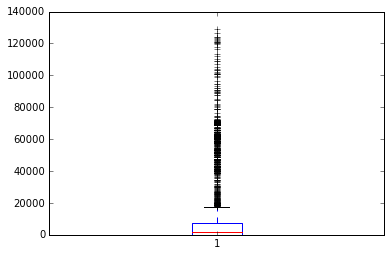

In [199]:
plt.boxplot(df[df['timelen'] >= 0]['timelen'])